## Cargar datos

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('once')

In [7]:
serie = pd.read_csv('data/serie_Demanda_Electrica_UE.csv', index_col=0, parse_dates=True)
serie.head()

,demand_EU
Date,
1979-01-01,9355907.3
1979-01-02,10725478.9
1979-01-03,11054636.7
1979-01-04,11051132.3
1979-01-05,10851689.6


In [16]:
# tipo de objeto
type(serie)

pandas.core.frame.DataFrame

In [9]:
serie = serie.asfreq('D')
serie.index

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=16802, freq='D')

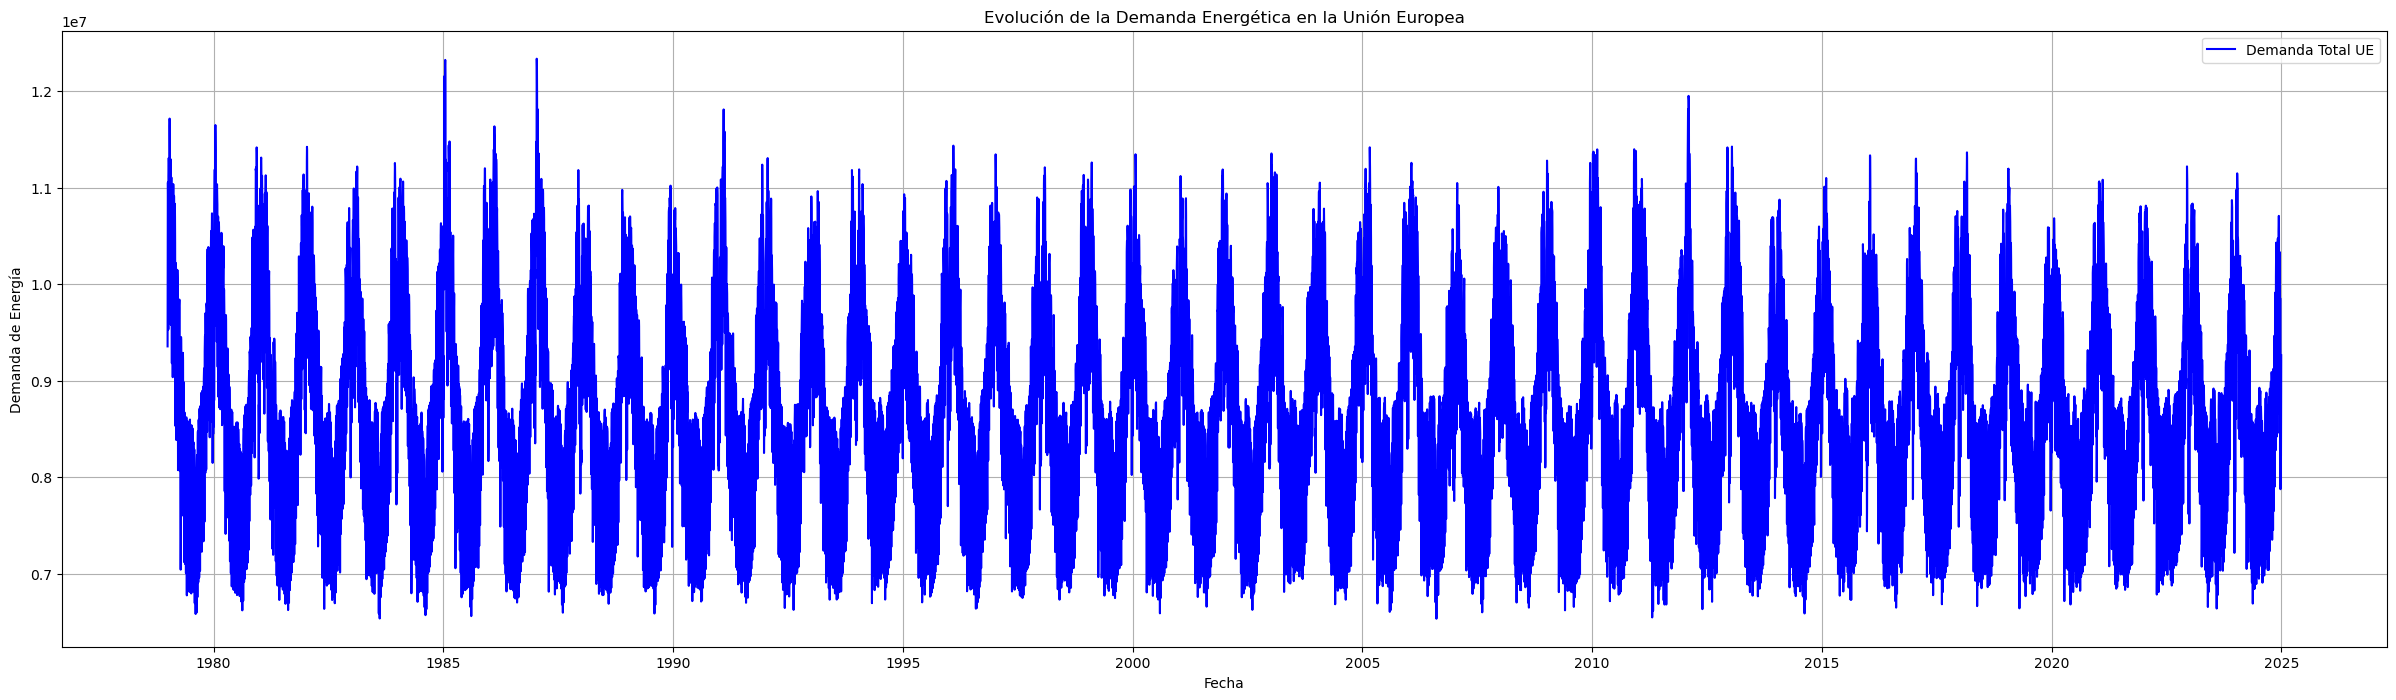

In [5]:
# Crear la figura y el gráfico
plt.figure(figsize=(30, 8))
plt.plot(serie.index, serie.values, label="Demanda Total UE", color="blue")

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.title("Evolución de la Demanda Energética en la Unión Europea")
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

## Singular ARIMA

In [17]:
# Establecer la frecuencia de los datos (por ejemplo, 'D' para diario, 'M' para mensual, 'Y' para anual)
frequency = 'D'  # Por ejemplo, si los datos son mensuales

# Definir el número de períodos en una temporada (ajustar según sea necesario)
seasonal_periods = 365  # Por ejemplo, si los datos son mensuales y tienen estacionalidad anual


# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(serie) * 0.8)
train, test = serie.iloc[:train_size], serie.iloc[train_size:]


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Ajustar el modelo ARIMA
arima_model_1 = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
arima_fit_1 = arima_model_1.fit()

In [ ]:
# Predecir tanto en el conjunto de entrenamiento como de test para comparar el pasado real y estimado
train_predictions = arima_fit_1.predict(start=0, end=len(train)-1, typ='levels')
arima_predictions_1 = arima_fit_1.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# Calcular métricas de validación
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Calculamos las métricas para el conjunto de prueba
arima_metrics_1 = calcular_metricas(test, arima_predictions_1)

# Imprimir las métricas
print("Métricas del Modelo SARIMA:", arima_metrics_1)

Métricas del Modelo SARIMA: (68990232764230.734, 8078356.845435628, 8306035.923605841, -67.32069147339851)


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


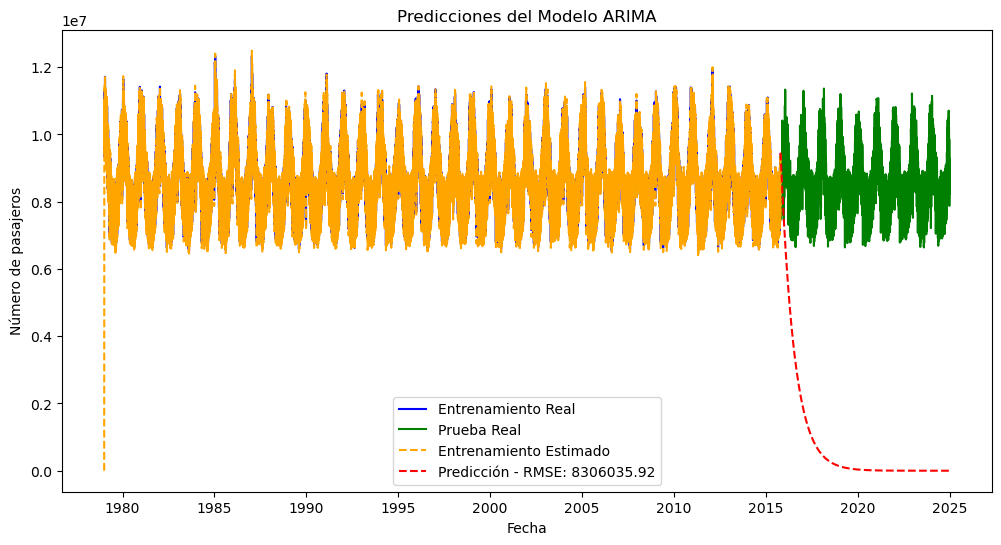

ARIMA - AIC: 399635.4553933561 BIC: 399657.9735884043


C:\Users\velir\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1021x70466 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 1 Axes>

ValueError: The 'color' keyword argument must have one color per dataset, but 3362 datasets and 1 colors were provided

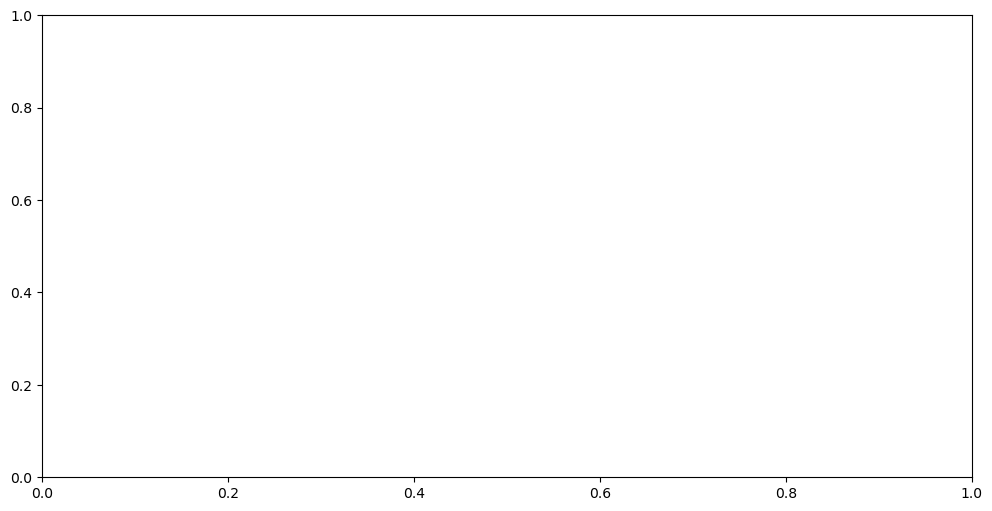

In [24]:
# Graficar los resultados: pasado real, pasado estimado y predicciones
plt.figure(figsize=(12, 6))

# Graficar la serie real del conjunto de entrenamiento y de prueba
plt.plot(train.index, train, label='Entrenamiento Real', color='blue')
plt.plot(test.index, test, label='Prueba Real', color='green')

# Graficar las predicciones del entrenamiento y prueba
plt.plot(train.index, train_predictions, label='Entrenamiento Estimado', linestyle='--', color='orange')
plt.plot(test.index, arima_predictions_1, label=f'Predicción - RMSE: {arima_metrics_1[2]:.2f}', linestyle='--', color='red')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicciones del Modelo ARIMA')
plt.legend()
plt.show()

# Imprimir el AIC y BIC del modelo
print("ARIMA - AIC:", arima_fit_1.aic, "BIC:", arima_fit_1.bic)

# Obtener los residuos del modelo
arima_residuals_1 = test - arima_predictions_1

# Graficar los residuos
plt.figure(figsize=(12, 6))
plt.plot(test.index, arima_residuals_1, label='ARIMA Residuos', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del Modelo ARIMA')
plt.legend()
plt.show()

# Graficar histograma de los residuos
plt.figure(figsize=(12, 6))
plt.hist(arima_residuals_1, bins=20, color='red', alpha=0.5, label='ARIMA Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos del Modelo ARIMA')
plt.legend()
plt.grid(True)
plt.show()

# Crear un DataFrame para los residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'ARIMA Residuos': arima_residuals_1
})

# Mostrar la tabla de resultados de residuos
print(residuals_df)

# Calcular y mostrar el coeficiente R²
r2_train = r2_score(train['Viajeros'], train_predictions)
print(f'Coeficiente de determinación R² en entrenamiento: {r2_train:.2f}')
print(f'Coeficiente de determinación R² en prueba: {arima_metrics_1[3]:.2f}')


## BUCLES ARIMA

parámetros
- **orden autorregresivo** $p$: por el gráfico de autocorrelación, hemos visto que hay correlación con los 3 primeros lags.

- **orden de diferenciación** $d = 0$: hemos comprobado que la serie es estacionaria con el test ADF.

- **orden de la media móvil** $q$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [14]:
# Función para calcular MAPE
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual-forecast) / actual)) *100

prueba = []
for p in [1,2]:
    for q in [1,2]:
        try:
            print(f"Entrenando modelo ARIMA({p},0,{q})...")
            
            # Ajustar el modelo ARIMA
            model = SARIMAX(serie, order=(p, 0, q), seasonal_order=(0, 0, 0, 0))
            model_fit = model.fit(maxiter=1000, disp=False)
            
            # Predicciones
            forecast = model_fit.forecast(steps=30)  # Predicción a corto plazo (últimos 30 días, ajusta según necesites)
            
            # Evaluación: calculando las métricas de evaluación
            aic = model_fit.aic
            bic = model_fit.bic
            
            # Supongamos que tienes los datos reales de los últimos 30 días en 'real_values'
            real_values = serie[-30:]  # Últimos 30 puntos como ejemplo (ajustar según tus datos reales)
            
            # Cálculos de error
            rmse = np.sqrt(mean_squared_error(real_values, forecast))
            mae = mean_absolute_error(real_values, forecast)
            mape = calculate_mape(real_values, forecast)
            
            # Residuos
            residuals = model_fit.resid
            
            # Test Ljung-Box para autocorrelación de los residuos
            ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)  # Puedes ajustar el número de lags
            
            # Guardar todos los resultados en una lista
            prueba.append({
                'p': p,
                'q': q,
                'AIC': aic,
                'BIC': bic,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'Ljung-Box p-value': ljung_box_result['lb_pvalue'][0]  # Valor p de la prueba de Ljung-Box
            })
        except Exception as e:
            print(f"Error con ARIMA({p},0,{q}): {e}")
            continue

print(prueba)

# Convertir los resultados a un DataFrame de pandas
#results_df = pd.DataFrame(results)

Entrenando modelo ARIMA(1,0,1)...
Error con ARIMA(1,0,1): 0
Entrenando modelo ARIMA(1,0,2)...
Error con ARIMA(1,0,2): 0
Entrenando modelo ARIMA(2,0,1)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(2,0,1): 0
Entrenando modelo ARIMA(2,0,2)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(2,0,2): 0
[]


In [ ]:
data = serie

# Definir el rango de parámetros para p, d, q (en tu caso d=0)
p_values = range(1, 6)  # Puedes ajustar este rango
q_values = range(1, 6)  # Puedes ajustar este rango
results = []  # Para almacenar los resultados

# Función para calcular MAPE
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Bucle para ajustar modelos ARIMA
for p in p_values:
    for q in q_values:
        try:
            print(f"Entrenando modelo ARIMA({p},0,{q})...")
            
            # Ajustar el modelo ARIMA
            model = ARIMA(data, order=(p, 0, q))  # d=0 porque nos dices que la serie es estacionaria
            model_fit = model.fit()
            
            # Predicciones
            forecast = model_fit.forecast(steps=30)  # Predicción a corto plazo (últimos 30 días, ajusta según necesites)
            
            # Evaluación: calculando las métricas de evaluación
            aic = model_fit.aic
            bic = model_fit.bic
            
            # Supongamos que tienes los datos reales de los últimos 30 días en 'real_values'
            real_values = data[-30:]  # Últimos 30 puntos como ejemplo (ajustar según tus datos reales)
            
            # Cálculos de error
            rmse = np.sqrt(mean_squared_error(real_values, forecast))
            mae = mean_absolute_error(real_values, forecast)
            mape = calculate_mape(real_values, forecast)
            
            # Residuos
            residuals = model_fit.resid
            
            # Test Ljung-Box para autocorrelación de los residuos
            ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)  # Puedes ajustar el número de lags
            
            # Guardar todos los resultados en una lista
            results.append({
                'p': p,
                'q': q,
                'AIC': aic,
                'BIC': bic,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'Ljung-Box p-value': ljung_box_result['lb_pvalue'][0]  # Valor p de la prueba de Ljung-Box
            })
        except Exception as e:
            print(f"Error con ARIMA({p},0,{q}): {e}")
            continue

# Convertir los resultados a un DataFrame de pandas
results_df = pd.DataFrame(results)

# Guardar en un archivo CSV
results_df.to_csv('modelos_ARIMA_v01.csv', index=False)

# Mostrar los resultados
results_df.head()

Entrenando modelo ARIMA(0,0,0)...
Error con ARIMA(0,0,0): 0
Entrenando modelo ARIMA(0,0,1)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(0,0,1): 0
Entrenando modelo ARIMA(0,0,2)...
Error con ARIMA(0,0,2): 0
Entrenando modelo ARIMA(0,0,3)...
Error con ARIMA(0,0,3): 0
Entrenando modelo ARIMA(0,0,4)...
Error con ARIMA(0,0,4): 0
Entrenando modelo ARIMA(0,0,5)...
Error con ARIMA(0,0,5): 0
Entrenando modelo ARIMA(1,0,0)...
Error con ARIMA(1,0,0): 0
Entrenando modelo ARIMA(1,0,1)...
Error con ARIMA(1,0,1): 0
Entrenando modelo ARIMA(1,0,2)...
Error con ARIMA(1,0,2): 0
Entrenando modelo ARIMA(1,0,3)...
Error con ARIMA(1,0,3): 0
Entrenando modelo ARIMA(1,0,4)...
Error con ARIMA(1,0,4): 0
Entrenando modelo ARIMA(1,0,5)...
Error con ARIMA(1,0,5): 0
Entrenando modelo ARIMA(2,0,0)...
Error con ARIMA(2,0,0): 0
Entrenando modelo ARIMA(2,0,1)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(2,0,1): 0
Entrenando modelo ARIMA(2,0,2)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(2,0,2): 0
Entrenando modelo ARIMA(2,0,3)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(2,0,3): 0
Entrenando modelo ARIMA(2,0,4)...
Error con ARIMA(2,0,4): 0
Entrenando modelo ARIMA(2,0,5)...
Error con ARIMA(2,0,5): 0
Entrenando modelo ARIMA(3,0,0)...
Error con ARIMA(3,0,0): 0
Entrenando modelo ARIMA(3,0,1)...
Error con ARIMA(3,0,1): 0
Entrenando modelo ARIMA(3,0,2)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(3,0,2): 0
Entrenando modelo ARIMA(3,0,3)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(3,0,3): 0
Entrenando modelo ARIMA(3,0,4)...
Error con ARIMA(3,0,4): 0
Entrenando modelo ARIMA(3,0,5)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(3,0,5): 0
Entrenando modelo ARIMA(4,0,0)...
Error con ARIMA(4,0,0): 0
Entrenando modelo ARIMA(4,0,1)...
Error con ARIMA(4,0,1): 0
Entrenando modelo ARIMA(4,0,2)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(4,0,2): 0
Entrenando modelo ARIMA(4,0,3)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Error con ARIMA(4,0,3): 0
Entrenando modelo ARIMA(4,0,4)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(4,0,4): 0
Entrenando modelo ARIMA(4,0,5)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(4,0,5): 0
Entrenando modelo ARIMA(5,0,0)...
Error con ARIMA(5,0,0): 0
Entrenando modelo ARIMA(5,0,1)...
Error con ARIMA(5,0,1): 0
Entrenando modelo ARIMA(5,0,2)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(5,0,2): 0
Entrenando modelo ARIMA(5,0,3)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(5,0,3): 0
Entrenando modelo ARIMA(5,0,4)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(5,0,4): 0
Entrenando modelo ARIMA(5,0,5)...


c:\Users\velir\anaconda3\envs\analisis_datos_3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error con ARIMA(5,0,5): 0


""
